Initialization

In [9]:
from PIL import Image
import numpy as np
import os
import pickle
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from filters import lowpass, highpass

data_dir = './data/'
C = 2048
R = 2048

images = []
data_dirs = []

for dirname in os.listdir(data_dir):
        if dirname.startswith('LuoJia1'):
            data_dirs.append(dirname)

for dirname in np.random.choice(data_dirs, 6, replace=False):
    im = Image.open('{}{}/{}_gec.tif'.format(data_dir, dirname, dirname))
    np_img = np.asarray(im.getdata())
    # restore normal FP representation, but magnified 1e5 times or it's too dark
    np_img = np_img ** (3 / 2) * 1e-5
    w, h = im.size
    np_img.shape = (h, w)
    images.append(cv2.resize(np_img, (R, C)))

In [10]:
def show_img(out_img):
    plt.imshow(Image.fromarray(out_img))

def show_imgs(imgs):
    fig = plt.figure(figsize=(24, 16))
    columns = 3
    rows = 2
    idx = 0
    for i in range(1, columns * rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(Image.fromarray(imgs[idx]).resize((1024, 1024)))
        idx += 1
    plt.show()

Load an image

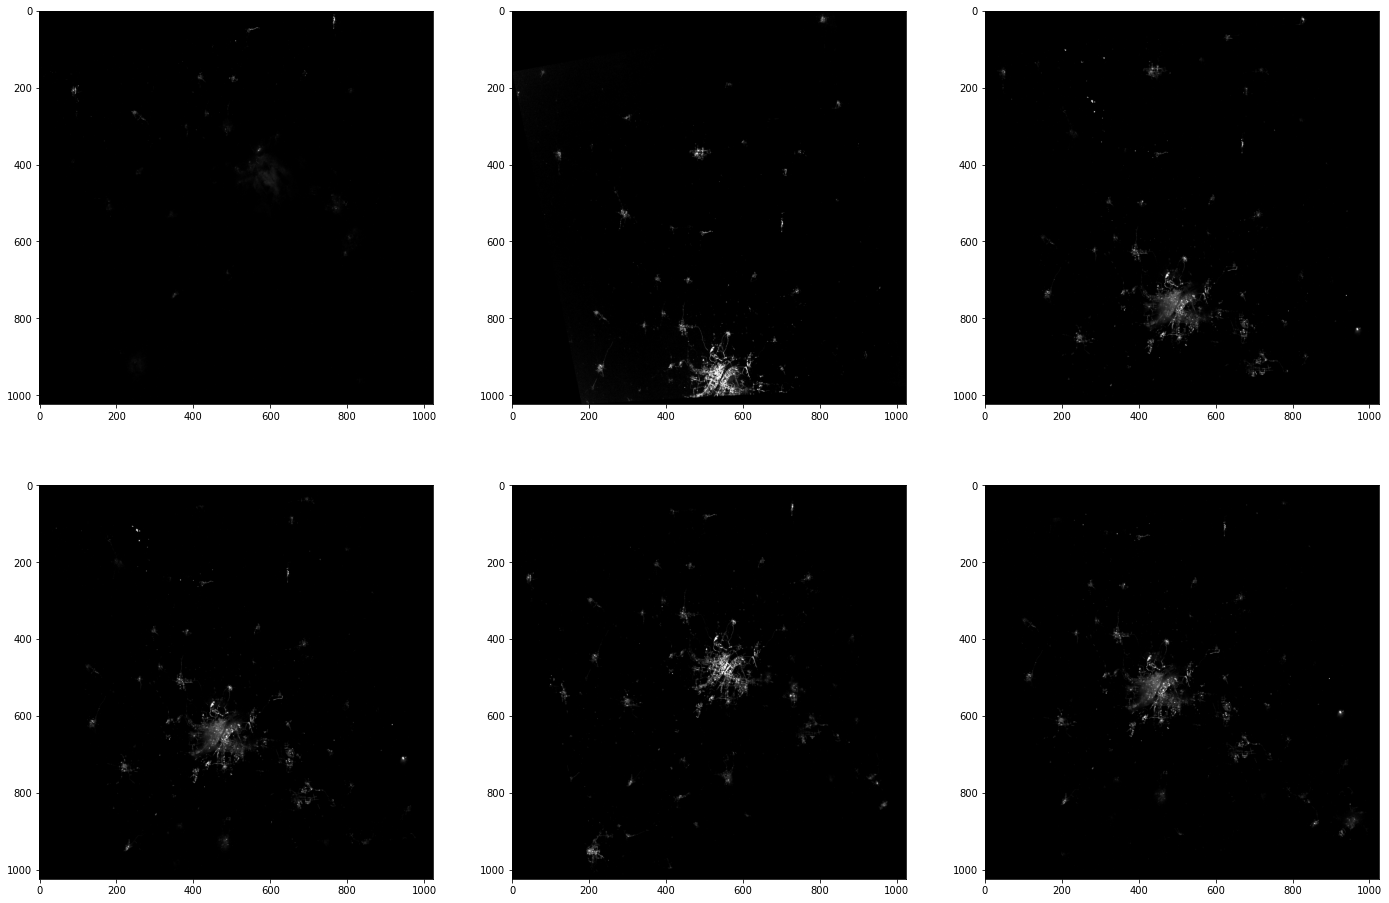

In [11]:
imgs = np.asarray(images)
imgs = torch.from_numpy(imgs).unsqueeze(1)
show_imgs(imgs.squeeze().numpy())

Apply unsharp mask, streetlights are sharpened and cloud remains

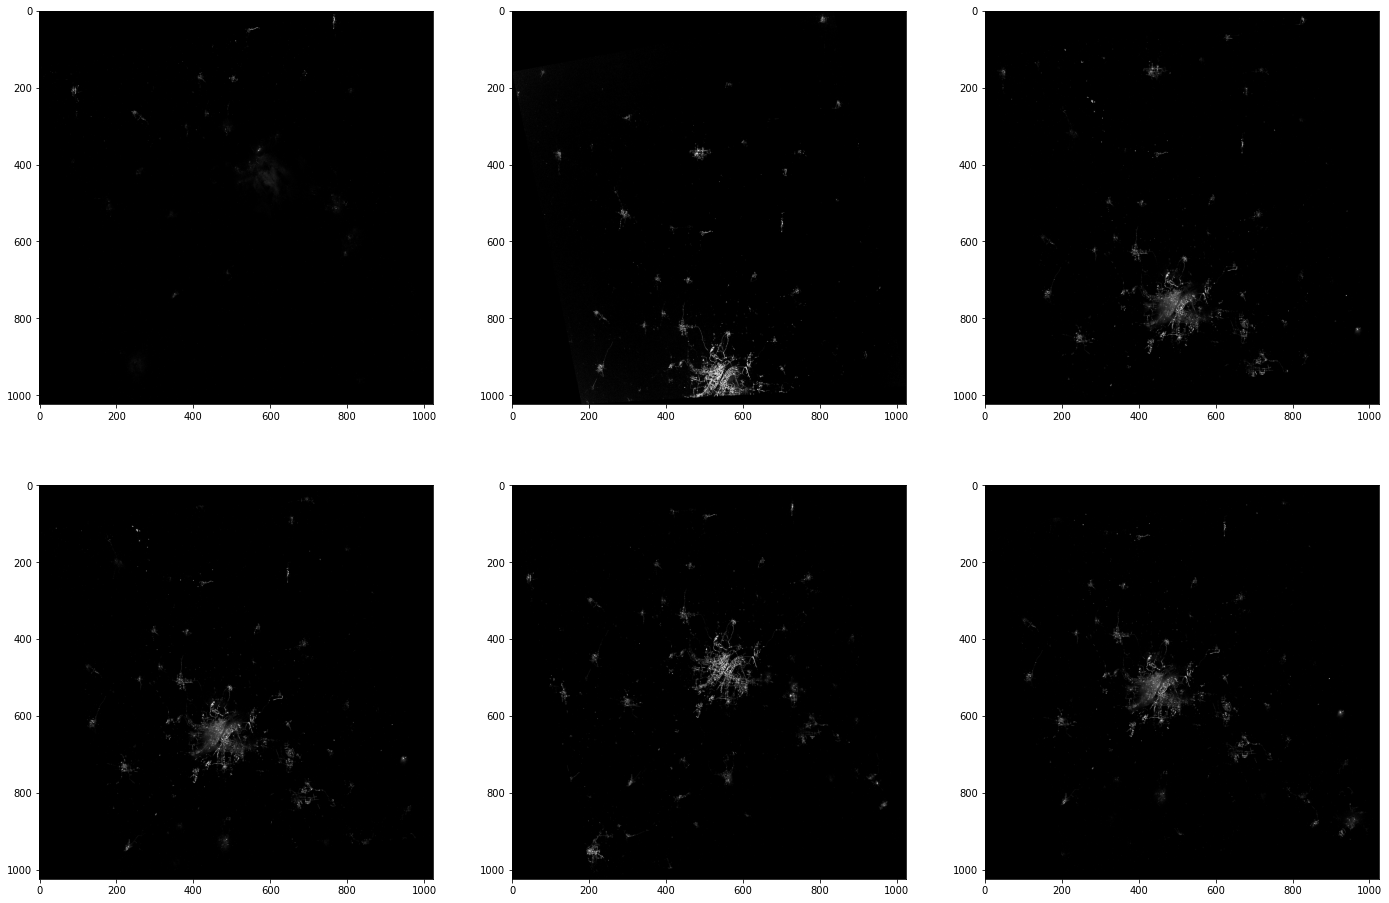

In [12]:
unsharp = np.genfromtxt('unsharp.csv', delimiter=',')
unsharp.shape = (1, 1, 3, 3)
unsharp = torch.from_numpy(unsharp)
out_imgs = F.conv2d(imgs, unsharp, padding=1)
show_imgs(out_imgs.squeeze().numpy())

Remove bright light, generate proto cloud mask

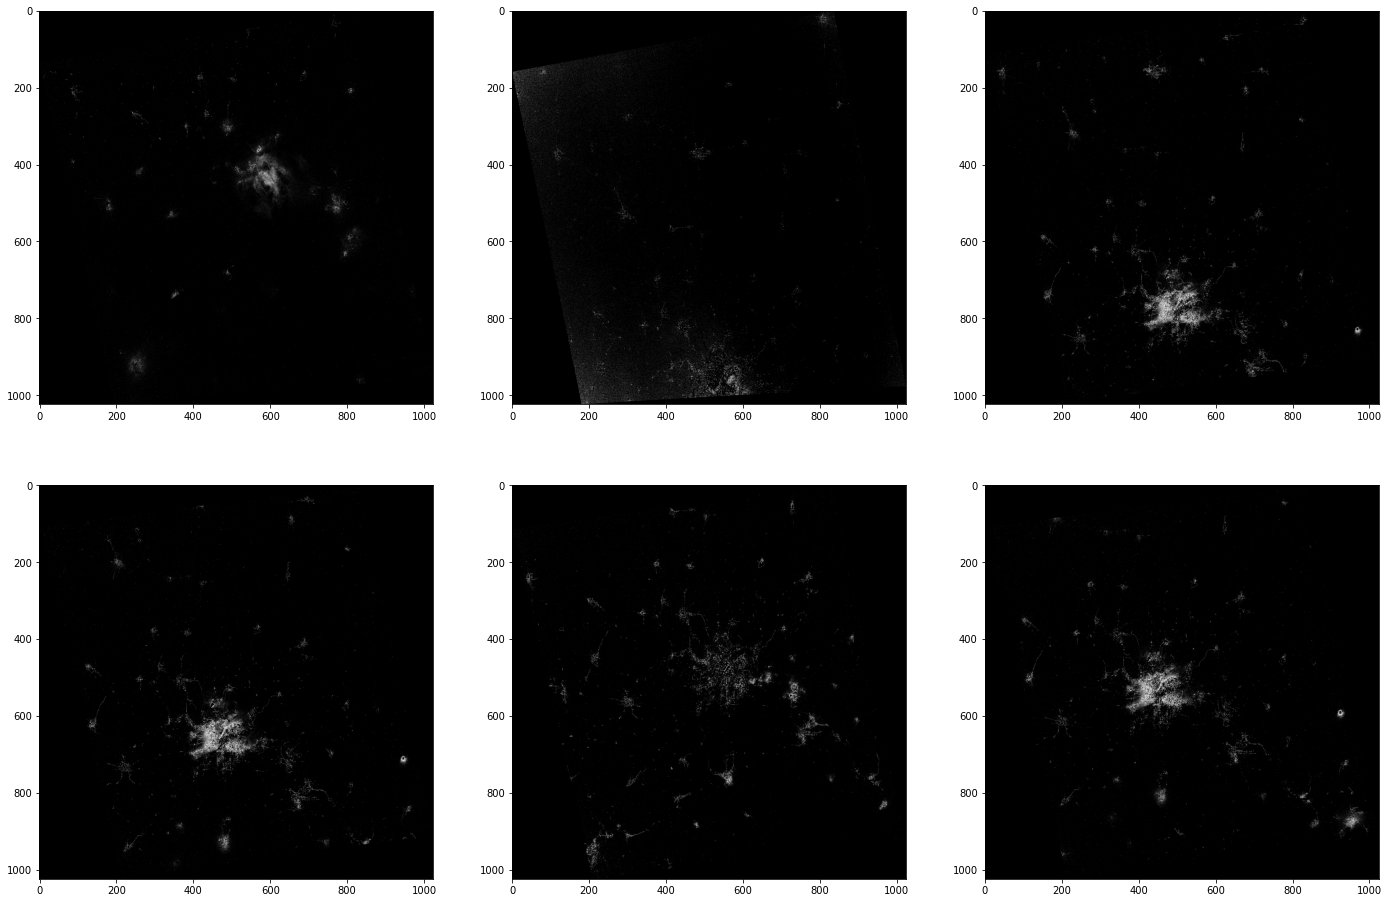

In [13]:
out_imgs = torch.from_numpy(lowpass(out_imgs.numpy(), 70))
show_imgs(out_imgs.squeeze().numpy() * 5)

Filter out streetlights by averaging

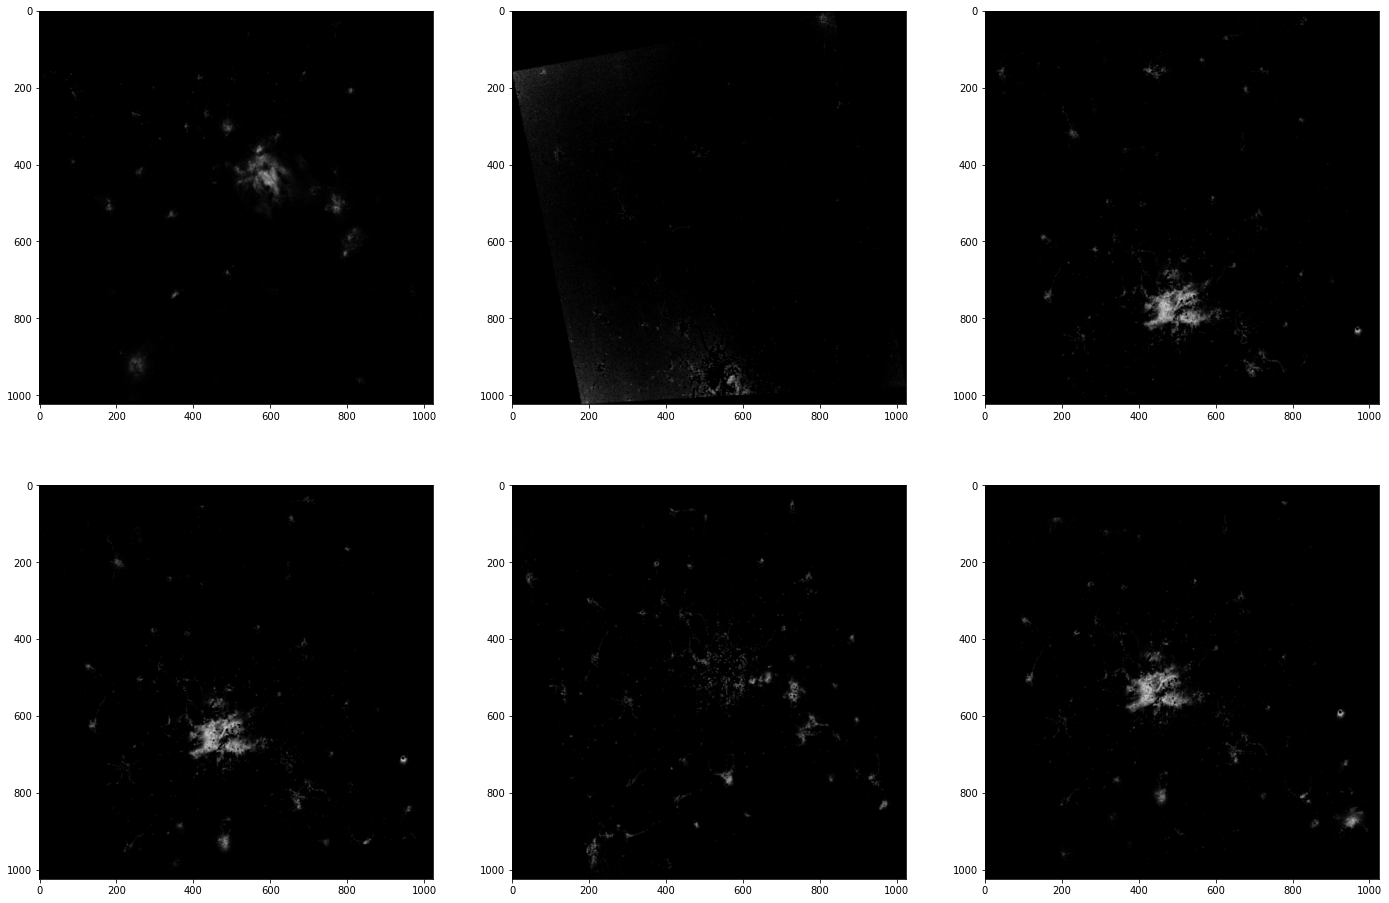

In [14]:
ksize = 7
avg_ker = np.ones((ksize, ksize)) / (ksize * ksize)
avg_ker.shape = (1, 1, ksize, ksize)
avg_ker = torch.from_numpy(avg_ker)
out_imgs = F.conv2d(out_imgs, avg_ker, padding=ksize // 2)
show_imgs(out_imgs.squeeze().numpy() * 5)

Remove noise

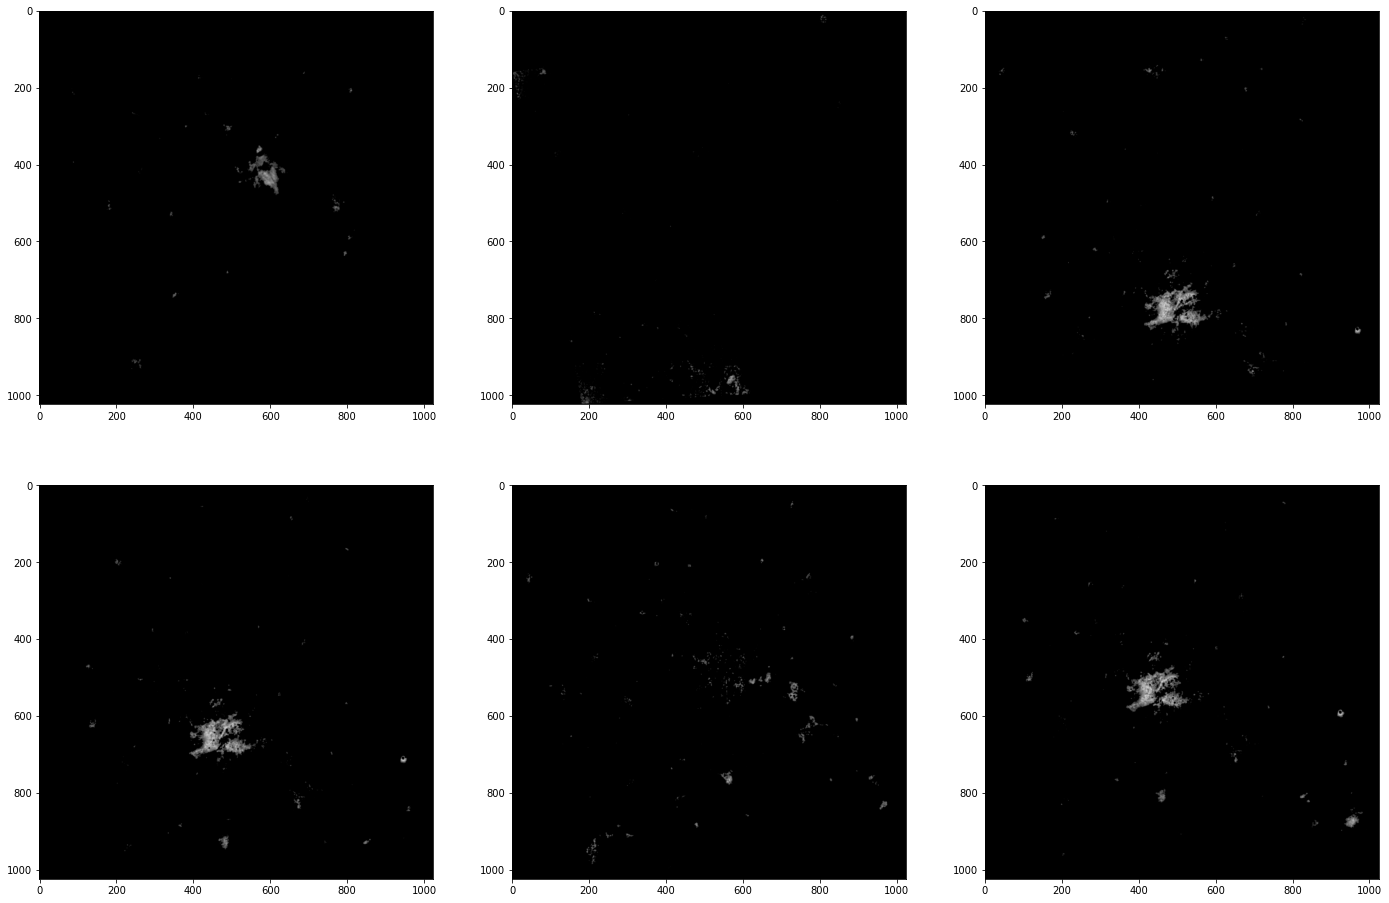

In [15]:
out_imgs = torch.from_numpy(highpass(out_imgs.numpy(), 10))
show_imgs(out_imgs.squeeze().numpy() * 5)

Adding an overlay cloud mask to original image

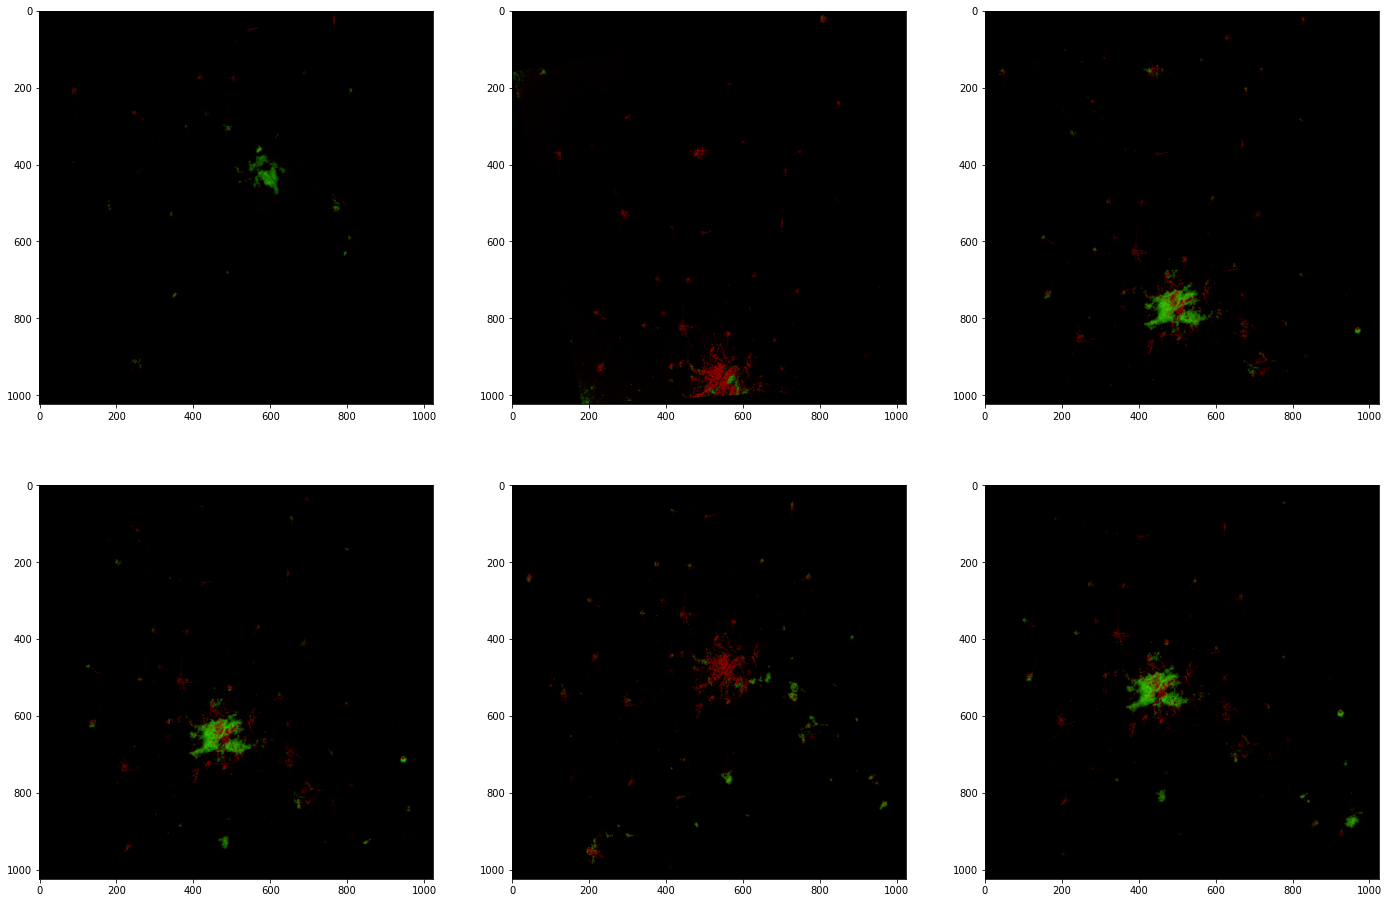

In [16]:
out_imgs_rgb = []
for (img, out_img) in zip(imgs.squeeze().numpy(), out_imgs.squeeze().numpy()):
    out_img_rgb = np.uint8(np.round(np.dstack((img, out_img * 5, np.zeros((R, C))))))
    out_imgs_rgb.append(out_img_rgb)

show_imgs(out_imgs_rgb)